In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

import json 


from sklearn.metrics import accuracy_score, log_loss, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import parallel_backend
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [2]:
df = pd.read_csv('robot_data/train_data.csv')

In [3]:
df.drop(columns=['year'], inplace=True)

## Shuffle dataset 

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,robot_gear_compression_diff_10,...,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,-0.283534,-0.837881,-3.597984,-16.554849,-11.389089,0.313589,-3.383178,-3.888150,-41.686393,-8.679487,...,5.967009,3.982668,1.174039,2.875162,1.261036,1.075103,-0.647793,-7.049394,moderate,-2.316919
1,-5.142603,-6.924267,-5.764813,8.312981,-18.293047,-6.217982,-12.931946,-7.927816,27.126724,-11.829680,...,9.444724,4.856028,-2.257161,3.229065,1.408525,1.305627,8.870408,-0.643271,high,-4.803426
2,-4.848547,-4.995010,-7.226481,-10.701620,-19.433779,-2.741447,-7.059371,-7.322945,-25.596221,-12.577888,...,4.949442,3.990456,0.198023,3.106897,2.477999,1.437429,10.733607,-6.703117,high,-8.582892
3,9.869959,7.545168,2.551952,-17.619413,-2.619880,2.451828,1.046444,-7.585662,-46.879829,6.168043,...,-32.464548,-13.233923,2.084878,3.155285,1.556361,1.596260,-11.369326,-198.627120,moderate,-13.795526
4,14.104006,15.290944,14.629884,1.226133,29.296182,10.653833,15.296214,8.833471,-32.645455,30.281082,...,3.692965,2.991953,2.221670,3.401771,2.434549,2.023328,-11.648547,77.482138,low,16.475245


В этом датасете есть только 1 категориальная фича, которую мы можем кодировать или через onehot или прост сопоставить каждому значению чилсо

## encode cat features with oneHotEncoder

In [5]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

# df_oh = oneHotEncode(df, ['gamma_ray'])
# df_oh.head()

## encode cat fetures with simple encoder 

In [6]:
def simple_encode(df, encode_map=None):
    if not encode_map:
        encode_map = {'low': 0.25, 'moderate': 0.5, 'high': 0.75, 'very high': 1}

    df['gamma_ray'] = df['gamma_ray'].map(encode_map)
    return df


# df_sim = simple_encode(df)
# df_sim.head()

Мы можем засплитить наш размеченный датасет на сет для тренировки и сет для теста модели 

In [7]:
# сплит не в процентах, а в количестве семплов потому что бибу соси

def split_train_test(df, split=600, enc_type='simple'):
    if enc_type == 'simple':
        df_ = simple_encode(df.copy())
        X_train, y_train= df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']
    elif enc_type == 'onehot':
        df_ = oneHotEncode(df.copy(), ['gamma_ray'])
        X_train, y_train = df_.iloc[split:].drop(columns=['target'], inplace=False), df_.iloc[split:]['target']
        X_test, y_test = df_.iloc[:split].drop(columns=['target'], inplace=False), df_.iloc[:split]['target']

    return X_train, y_train, X_test, y_test

# X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

# Save model

In [8]:
# настятельно рекомендую юзать поле enc (на каком энкодере обучалась)
# acc ввеодить без точки, eg: r2 = 0.979 => acc = 979
def save_model(model, acc, enc=''):
    json_arch = model.to_json()
    if enc:
        model.save('./models/model_{}_{}.h5'.format(acc, enc))
        with open('./arch/model_{}_{}.json'.format(acc, enc), 'w') as out:
            out.write(json_arch)
    else:
        model.save('./models/model_{}.h5'.format(acc))
        with open('./arch/model_{}.json'.format(acc), 'w') as out:
            out.write(json_arch)

## Train mlp 

Создавать все модели меняя эту функцию не самая лучшая идея, поэтому когда делаете новую модель лучше всего написать новую функцию аналагичную этой (да и вообще лучше целую секцию)

In [9]:
def create_model(n_cols):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

r2 metric 

${R^2 = \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}}$

${\hat{y_i}}$ -- предсказанное значение 
${\bar{y}}$ -- среднее значение 

In [10]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 0 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0, ну или если это долго то перед комитом очистить оутпуты)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=400, verbose=verbose)

Вся инфа про обучение лежит в history

In [104]:
history.history['val_coeff_determination'][-10:]

[0.954663671650985,
 0.9532649177100376,
 0.9533832158201407,
 0.9565746234013484,
 0.9501687149616835,
 0.9580100864227896,
 0.9519670936672147,
 0.9602311026535607,
 0.9531387005693246,
 0.9597226503195055]

полный аналог r2 метрики определенной выше, но написсаный на numpy (r2 метрика выше возвращяет tensor, что нужно для использования в керасе, но это не удобно чтобы тестить)

In [12]:
def np_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

Следующие три ячейки тут потому что я так хочу 

In [13]:
y_pred = model.predict(X_test)
y_pred.shape = (y_pred.shape[0], )
np_r2_score(y_test, y_pred)

0.9620511907304891

In [14]:
(y_test - y_pred).mean()

0.23052085471795541

In [15]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 67us/step


[12.936997877756754, 0.9407667374610901]

In [16]:
save_model(model, 940, 'simple')

# train model on full dataset

In [18]:
def train_full_set(enc='simple', create_model=create_model, epochs=400, verbose=0):
    dataset = pd.read_csv('./robot_data/train_data.csv')    
    dataset = dataset.drop(columns=['year'])
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    X_train, y_train, X_test, y_test = split_train_test(dataset, 0, enc)
    model = create_model(X_train.shape[1])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=verbose)
    return model 

In [19]:
model = train_full_set()

#model.evaluate(X_train, y_train)

# try learn not only nn's

In [135]:
regressors = [
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()]

In [142]:
dataset = pd.read_csv('./robot_data/train_data.csv') 
dataset = dataset.sample(frac=1).reset_index(drop=True)

скейлим датасет и сопоставляем значения категориям 

In [143]:
dataset = simple_encode(dataset)

X = dataset.values[0::, :-2:]
y = dataset.values[0::, -1]

scaler = StandardScaler()

X = scaler.fit_transform(X)
X = np.c_[(X, dataset.values[0::, -2])]

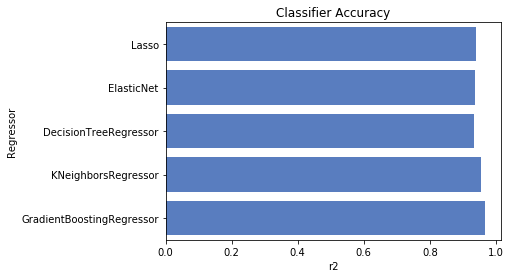

In [144]:
log_cols = ["Regressor", "r2"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for reg in regressors:
    name = reg.__class__.__name__
    
    acc = cross_validate(reg, X, y, scoring=['r2', 'neg_mean_squared_error'], cv=3, n_jobs=-1)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for reg in acc_dict:
    log_entry = pd.DataFrame([[reg, acc_dict[reg]['test_r2'].mean()]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='r2', y='Regressor', data=log, color="b")

# train gradiend boosting regressor

Вообще этот регрессор выглядит многообещающе, но я потратил на него уже три попытки и все были с отрицательным r2 -> я както неправильно подготавливаю данные. Скорее всего я где-то неправ со scaler'ом. А мб он прост не работает и не надо тратить на него время

In [145]:
X_train, X_test = X[600:], X[:600]
y_train, y_test = y[600:], y[:600]

gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [148]:
y_preds = gbr_reg.predict(X_test)

In [149]:
gbr_reg.score(X_test, y_test)

0.9926041262413985

# Train mlp w\ dropout

In [42]:

def create_dropout_model(n_cols):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

In [ ]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 1 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=400, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               18560     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
__________

Epoch 39/400
2130/2130 [==============================] - 0s 209us/step - loss: 67.1333 - coeff_determination: 0.8835 - val_loss: 131.2863 - val_coeff_determination: 0.7954
Epoch 40/400
2130/2130 [==============================] - 0s 196us/step - loss: 72.4036 - coeff_determination: 0.8917 - val_loss: 184.2684 - val_coeff_determination: 0.7621
Epoch 41/400
2130/2130 [==============================] - 0s 233us/step - loss: 67.6583 - coeff_determination: 0.8938 - val_loss: 42.5240 - val_coeff_determination: 0.8721
Epoch 42/400
2130/2130 [==============================] - 0s 213us/step - loss: 95.5604 - coeff_determination: 0.8858 - val_loss: 153.6899 - val_coeff_determination: 0.8133
Epoch 43/400
2130/2130 [==============================] - 0s 205us/step - loss: 120.2085 - coeff_determination: 0.8520 - val_loss: 63.4563 - val_coeff_determination: 0.8710
Epoch 44/400
2130/2130 [==============================] - 0s 201us/step - loss: 58.8465 - coeff_determination: 0.8937 - val_loss: 29.904

2130/2130 [==============================] - 1s 244us/step - loss: 26.6102 - coeff_determination: 0.9478 - val_loss: 76.5594 - val_coeff_determination: 0.8356
Epoch 87/400
2130/2130 [==============================] - 0s 225us/step - loss: 70.3040 - coeff_determination: 0.9114 - val_loss: 45.1216 - val_coeff_determination: 0.8348
Epoch 88/400
2130/2130 [==============================] - 1s 266us/step - loss: 38.5460 - coeff_determination: 0.9289 - val_loss: 41.3845 - val_coeff_determination: 0.8725
Epoch 89/400
2130/2130 [==============================] - 1s 258us/step - loss: 29.8007 - coeff_determination: 0.9426 - val_loss: 39.3949 - val_coeff_determination: 0.8582
Epoch 90/400
2130/2130 [==============================] - 1s 252us/step - loss: 68.6550 - coeff_determination: 0.9164 - val_loss: 65.7041 - val_coeff_determination: 0.8085
Epoch 91/400
2130/2130 [==============================] - 0s 234us/step - loss: 39.3135 - coeff_determination: 0.9341 - val_loss: 92.5654 - val_coeff_det

2130/2130 [==============================] - 1s 235us/step - loss: 32.6993 - coeff_determination: 0.9485 - val_loss: 60.5207 - val_coeff_determination: 0.7907
Epoch 134/400
2130/2130 [==============================] - 0s 219us/step - loss: 32.3390 - coeff_determination: 0.9422 - val_loss: 96.9479 - val_coeff_determination: 0.7678
Epoch 135/400
2130/2130 [==============================] - 0s 229us/step - loss: 57.9643 - coeff_determination: 0.9125 - val_loss: 174.0304 - val_coeff_determination: 0.6987
Epoch 136/400
2130/2130 [==============================] - 0s 222us/step - loss: 27.8689 - coeff_determination: 0.9341 - val_loss: 58.7019 - val_coeff_determination: 0.8031
Epoch 137/400
2130/2130 [==============================] - 0s 221us/step - loss: 42.8729 - coeff_determination: 0.9364 - val_loss: 69.5073 - val_coeff_determination: 0.7867
Epoch 138/400
2130/2130 [==============================] - 0s 205us/step - loss: 34.8442 - coeff_determination: 0.9468 - val_loss: 77.6386 - val_coe

2130/2130 [==============================] - 1s 238us/step - loss: 22.2265 - coeff_determination: 0.9605 - val_loss: 57.2719 - val_coeff_determination: 0.7931
Epoch 181/400
2130/2130 [==============================] - 1s 243us/step - loss: 19.1999 - coeff_determination: 0.9659 - val_loss: 83.8732 - val_coeff_determination: 0.7643
Epoch 182/400
2130/2130 [==============================] - 1s 261us/step - loss: 25.7889 - coeff_determination: 0.9512 - val_loss: 83.5108 - val_coeff_determination: 0.7217
Epoch 183/400
2130/2130 [==============================] - 1s 236us/step - loss: 12.2469 - coeff_determination: 0.9612 - val_loss: 49.9696 - val_coeff_determination: 0.8111
Epoch 184/400
2130/2130 [==============================] - 0s 228us/step - loss: 21.8323 - coeff_determination: 0.9601 - val_loss: 60.8454 - val_coeff_determination: 0.7823
Epoch 185/400
2130/2130 [==============================] - 0s 219us/step - loss: 13.4444 - coeff_determination: 0.9721 - val_loss: 100.5559 - val_coe

2130/2130 [==============================] - 0s 225us/step - loss: 39.4181 - coeff_determination: 0.9423 - val_loss: 63.9465 - val_coeff_determination: 0.7669
Epoch 228/400
2130/2130 [==============================] - 0s 208us/step - loss: 22.4130 - coeff_determination: 0.9624 - val_loss: 99.6078 - val_coeff_determination: 0.7494
Epoch 229/400
2130/2130 [==============================] - 0s 223us/step - loss: 20.0328 - coeff_determination: 0.9543 - val_loss: 65.6156 - val_coeff_determination: 0.7559
Epoch 230/400
2130/2130 [==============================] - 0s 233us/step - loss: 39.4613 - coeff_determination: 0.9401 - val_loss: 49.7384 - val_coeff_determination: 0.7957
Epoch 231/400
2130/2130 [==============================] - 0s 225us/step - loss: 25.6021 - coeff_determination: 0.9582 - val_loss: 134.2016 - val_coeff_determination: 0.7162
Epoch 232/400
2130/2130 [==============================] - 1s 239us/step - loss: 28.9934 - coeff_determination: 0.9526 - val_loss: 70.4562 - val_coe

2130/2130 [==============================] - 1s 243us/step - loss: 38.3938 - coeff_determination: 0.9490 - val_loss: 69.3086 - val_coeff_determination: 0.7596
Epoch 275/400
2130/2130 [==============================] - 0s 228us/step - loss: 9.1521 - coeff_determination: 0.9792 - val_loss: 64.4540 - val_coeff_determination: 0.7739
Epoch 276/400
2130/2130 [==============================] - 0s 231us/step - loss: 9.8945 - coeff_determination: 0.9765 - val_loss: 77.8896 - val_coeff_determination: 0.7595
Epoch 277/400
2130/2130 [==============================] - 1s 236us/step - loss: 9.6822 - coeff_determination: 0.9781 - val_loss: 57.6350 - val_coeff_determination: 0.7890
Epoch 278/400
2130/2130 [==============================] - 0s 223us/step - loss: 12.4881 - coeff_determination: 0.9738 - val_loss: 77.1130 - val_coeff_determination: 0.7628
Epoch 279/400
2130/2130 [==============================] - 1s 247us/step - loss: 19.5755 - coeff_determination: 0.9683 - val_loss: 69.8853 - val_coeff_d

2130/2130 [==============================] - 1s 244us/step - loss: 29.8644 - coeff_determination: 0.9557 - val_loss: 77.2012 - val_coeff_determination: 0.7491
Epoch 322/400
2130/2130 [==============================] - 1s 254us/step - loss: 13.9370 - coeff_determination: 0.9715 - val_loss: 64.9021 - val_coeff_determination: 0.7539
Epoch 323/400
2130/2130 [==============================] - 1s 243us/step - loss: 12.4681 - coeff_determination: 0.9697 - val_loss: 53.3128 - val_coeff_determination: 0.7884
Epoch 324/400
2130/2130 [==============================] - 1s 264us/step - loss: 12.2461 - coeff_determination: 0.9726 - val_loss: 131.4472 - val_coeff_determination: 0.7063
Epoch 325/400
2130/2130 [==============================] - 1s 242us/step - loss: 13.4006 - coeff_determination: 0.9727 - val_loss: 62.9310 - val_coeff_determination: 0.7600
Epoch 326/400
2130/2130 [==============================] - 1s 243us/step - loss: 12.7071 - coeff_determination: 0.9717 - val_loss: 100.5292 - val_co

In [31]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 83us/step


[68.91406753540039, 0.6779361319541931]

# Predict on test set

In [24]:
def get_preds_on_test(model, enc='simple'):
    df = pd.read_csv('./robot_data/test_data.csv')
    df = df.drop(columns=['year', 'target'])
    
    if enc == 'simple':
        df = simple_encode(df.copy())
        
    elif enc == 'onehot':
        df = oneHotEncode(df.copy())
        
    y_pred = model.predict(df)
    return y_pred

# submit funcion

In [37]:
def create_submition(model, enc='simple', subm_name=None):
    df = pd.read_csv('./robot_data/test_data.csv')
    years = df['year']
    
    y_pred = get_preds_on_test(model)
    y_pred = y_pred.reshape(1000)
    
    
    d = {'year': years.values, 'target': y_pred}
    ans = pd.DataFrame(d)
    ans = ans.set_index('year')
    print(ans)
    subm_name = subm_name if subm_name else 'submission_.csv'
    ans.to_csv(subm_name)

In [41]:
create_submition(model, subm_name='./submissions/subm_mlp_full_set.csv')

         target
year           
5282 -13.278259
5283 -16.040136
5284 -19.117350
5285 -20.228075
5286 -19.922838
5287 -18.645390
5288 -19.675907
5289 -18.406223
5290 -20.618595
5291 -21.231966
5292 -21.152273
5293 -20.578045
5294 -18.423748
5295 -12.994398
5296 -10.995569
5297 -10.950588
5298 -11.344562
5299  -9.491128
5300  -8.498999
5301 -15.678307
5302  -6.798501
5303  -6.413476
5304  -7.818804
5305  -8.990040
5306  -9.916883
5307 -14.028955
5308 -15.059694
5309 -11.120197
5310 -11.621145
5311 -12.333111
...         ...
6252 -14.664707
6253 -15.011763
6254 -12.655294
6255 -10.717266
6256 -10.490582
6257  -9.391224
6258  -9.850891
6259  -9.044678
6260  -6.130199
6261  -5.609916
6262  -2.094820
6263  -2.898294
6264  -1.932680
6265  -2.486497
6266  -7.086571
6267  -7.763986
6268  -8.485709
6269 -10.569044
6270 -11.841455
6271 -12.094532
6272 -13.389515
6273 -15.917620
6274 -15.614767
6275 -15.726152
6276 -17.932087
6277 -16.443579
6278 -14.203053
6279 -16.429148
6280 -12.717262
6281 -10